In [117]:
!pip install pymc3
!pip install GPy

In [118]:
import pymc3 as pm
import GPy as GPy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
from scipy.stats import linregress 
%matplotlib inline

In [119]:
from google.colab import files
uploaded = files.upload()


Saving test.csv to test (2).csv
Saving train.csv to train (2).csv


In [120]:
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

Data Exploration

In [121]:
#generate the time intervals
time = np.linspace(0,1,100)

In [122]:
df_train.head()

Id         0         1         2  ...        97        98        99  Category
0  120  0.147298 -0.142030  0.091737  ... -0.008333  0.168574  0.123273         0
1  121  0.115710  0.105061  0.038446  ...  0.020398  0.039687  0.217384         0
2  122 -0.548826 -0.466551 -0.650890  ... -0.019942  0.058902  0.053936         0
3  123  0.192618  0.291155 -0.042980  ...  0.190920  0.251743  0.337730         1
4  124  0.075706  0.069045 -0.019818  ...  0.554588  0.471489  0.384229         1

[5 rows x 102 columns]

In [123]:
y=(df_train[df_train.columns[1:-1]])


In [124]:
print(y.shape)
print(df_train.shape)
print(df_test.shape)
print(time.shape)

(75, 100)
(75, 102)
(120, 101)
(100,)


In [125]:
y.head()

0         1         2  ...        97        98        99
0  0.147298 -0.142030  0.091737  ... -0.008333  0.168574  0.123273
1  0.115710  0.105061  0.038446  ...  0.020398  0.039687  0.217384
2 -0.548826 -0.466551 -0.650890  ... -0.019942  0.058902  0.053936
3  0.192618  0.291155 -0.042980  ...  0.190920  0.251743  0.337730
4  0.075706  0.069045 -0.019818  ...  0.554588  0.471489  0.384229

[5 rows x 100 columns]

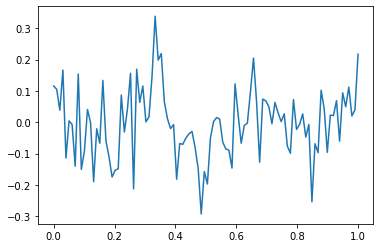

In [126]:
plt.plot(time,y.iloc[1])

In [127]:
#CHOOSE INDEX (temporary until model is automated)
index=63

In [128]:
y_all=(df_train[df_train.columns[1:-1]])
print(y_all.shape)
print(time.shape)
y=y_all.iloc[index]
print(y.shape)
x=time[:,None]
print(x.shape)

(75, 100)
(100,)
(100,)
(100, 1)


**TEST MODEL**
 - not including the generic component initially




In [129]:
with pm.Model() as model:
    
    
    
    #  periodic component x 
    n_per = pm.HalfCauchy("n_per", beta=5, testval=1)
    #period  = pm.Normal("period", mu=1, sigma=2)
    smooth = pm.Gamma("smooth ", alpha=1, beta=1)
    
    cov_seasonal = n_per**2 * pm.gp.cov.Cosine(1, smooth)     
    gp1 = pm.gp.Marginal(cov_func=cov_seasonal)

    #  linear component x 
    tau = pm.HalfCauchy("tau", beta=2,  testval=1)
    c  = pm.Normal("c", mu=0, sigma=1) 
    
    cov_linear = tau * pm.gp.cov.Linear(1, c)     
    gp2 = pm.gp.Marginal(cov_func=cov_linear)

    # gp represents f1 + f2 + f3.
    gp =  gp1 +gp2 #+gp3 

    print("made it here2")
    # noise model
    sigma = pm.HalfCauchy("sigma", beta=5, testval=0.5)
    f=gp.marginal_likelihood("f", x, y, noise=sigma)

    print("made it here3")
    # this line calls an optimizer to optimize the marginal likelihood
    mp = pm.find_MAP(include_transformed=True)

    print("made it here4")
    


I made it here2
I made it here3


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = 82.578, ||grad|| = 0.00026181: 100%|██████████| 53/53 [00:00<00:00, 189.21it/s]  


I made it here4


In [130]:
#we can do  an approximated inference
with model:
  inference = pm.ADVI()
  approx = pm.fit(60000, method=inference)

print("made it here5")   
posterior = approx.sample(draws=500)
   

Average Loss = -73.276: 100%|██████████| 60000/60000 [05:40<00:00, 176.21it/s]
Finished [100%]: Average Loss = -73.278


I made it here5


**MAKE PREDICTIONS WITH TEST MODEL**

In [132]:
#MAKE MODEL PREDICTIONS
    

#CREATE NEW TIME
time_new=np.linspace(0,1,100)
x_new=time_new[:,None]


print(x_new.shape)
print(y.shape)

(100, 1)
(100,)


In [133]:


#generic term
#f1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y[:,0], "noise": sigma})
#y1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y[:,0], "noise": sigma}, pred_noise=True)
#periodic term
f1_pred = gp1.predict(x_new, point=mp, given={"gp": gp, "X": x_new, "y": y[:,0], "noise": sigma})
y1_pred = gp1.predict(x_new, point=mp, given={"gp": gp, "X": x_new, "y": y[:,0], "noise": sigma}, pred_noise=True)
#linear term
f2_pred = gp2.predict(x_new, point=mp, given={"gp": gp, "X": x_new, "y": y[:,0], "noise": sigma})
y2_pred = gp2.predict(x_new, point=mp, given={"gp": gp, "X": x_new, "y": y[:,0], "noise": sigma}, pred_noise=True)




ValueError: ignored

In [114]:
print(f2_pred[0])
print(len(f2_pred[0]))
predict_y=f2_pred[0]

print(x.shape)
print(predict_y)

[[ 4.46316799e-18  4.46316799e-18  4.46316799e-18 ...  4.46316799e-18
   4.46316799e-18  4.46316799e-18]
 [-4.77172581e-16 -4.77172581e-16 -4.77172581e-16 ... -4.77172581e-16
  -4.77172581e-16 -4.77172581e-16]
 [-9.58808330e-16 -9.58808330e-16 -9.58808330e-16 ... -9.58808330e-16
  -9.58808330e-16 -9.58808330e-16]
 ...
 [-4.67142045e-14 -4.67142045e-14 -4.67142045e-14 ... -4.67142045e-14
  -4.67142045e-14 -4.67142045e-14]
 [-4.71958402e-14 -4.71958402e-14 -4.71958402e-14 ... -4.71958402e-14
  -4.71958402e-14 -4.71958402e-14]
 [-4.76774760e-14 -4.76774760e-14 -4.76774760e-14 ... -4.76774760e-14
  -4.76774760e-14 -4.76774760e-14]]
100
(100, 1)
[[ 4.46316799e-18  4.46316799e-18  4.46316799e-18 ...  4.46316799e-18
   4.46316799e-18  4.46316799e-18]
 [-4.77172581e-16 -4.77172581e-16 -4.77172581e-16 ... -4.77172581e-16
  -4.77172581e-16 -4.77172581e-16]
 [-9.58808330e-16 -9.58808330e-16 -9.58808330e-16 ... -9.58808330e-16
  -9.58808330e-16 -9.58808330e-16]
 ...
 [-4.67142045e-14 -4.67142045e-

In [106]:
slope, intercept, r_value, p_value, std_err = linregress(x_new[:,0], f2_pred[0])
print(slope)

0.9954646329397824


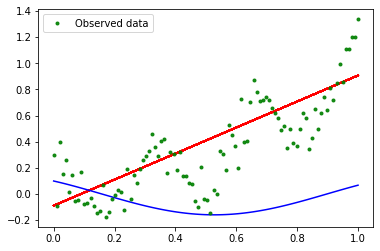

In [84]:
plt.figure()

plt.plot(x_new, y, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);
plt.plot(x_new,f2_pred[0], c='r');
plt.plot(x_new,f1_pred[0], c='b');
plt.legend()

In [ ]:
sample_f = multivariate_normal(f_pred[0],f_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_f.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line


plt.figure()
#we sample 10 regression lines from the posterior
sample_y = multivariate_normal(y_pred[0],y_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_y.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X_n, y_n, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);

### **`THE BASIC MODEL`**

In [ ]:
#define  basis functions
#def make_basis(x):
    # the components are 1,x, cos(2 \pi x), sin(2 \pi x)...
    #periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    #return np.hstack([np.ones((x.shape[0],1)),x, periodic ]) 

#  periodic basis starts at column:
col_per = 2

#baseline model
def run_model(x,y):   
#def run_model(x,y,plot=False):    
    #  generic component x 
    #η_s = pm.HalfCauchy("η_s", beta=5, testval=1)
    #ℓ_smooth = pm.Gamma("ℓ_smooth ", alpha=1, beta=1 )
    #cov_generic = η_s**2 * pm.gp.cov.ExpQuad(1,  ℓ_smooth)     
    #gp3 = pm.gp.Marginal(cov_func=cov_generic)

  with pm.Model() as model:

    n_per = pm.HalfCauchy("n_per", beta=5, testval=1)
    #period  = pm.Normal("period", mu=1, sigma=2)
    smooth = pm.Gamma("smooth ", alpha=1, beta=1)
    
    cov_seasonal = n_per**2 * pm.gp.cov.Cosine(1, smooth)     
    gp1 = pm.gp.Marginal(cov_func=cov_seasonal)


    #  linear component x 
    tau = pm.HalfCauchy("tau", beta=2,  testval=1)
    c  = pm.Normal("c", mu=0, sigma=1) 
    
    cov_linear = tau * pm.gp.cov.Linear(1, c)     
    gp2 = pm.gp.Marginal(cov_func=cov_linear)

    # gp represents f1 + f2 + f3.
    gp =  gp1 +gp2 #+gp3 

    print("I made it here2")
    # noise model
    sigma = pm.HalfCauchy("sigma", beta=5, testval=0.5)
    f=gp.marginal_likelihood("f", x, y, noise=sigma)

    print("I made it here3")
    # this line calls an optimizer to optimize the marginal likelihood
    mp = pm.find_MAP(include_transformed=True)


    print("I made it here4")
    #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)

    print("I made it here5")   
    posterior = approx.sample(draws=500)
    
    #MAKE MODEL PREDICTIONS
    
    #linear term - WHAT IS THE SLOPE?
    #progress with TAU just to build code and figure this out later

    slope=np.mean(posterior['tau'][:,1])
    print(slope)

    if slope >0:
      return 1
    else: 
      return 0

In [ ]:
print(y.shape)
print(time.shape)

(100,)
(100,)



#Try on the training set

In [ ]:
print(df_train.shape)
print(df_train.shape[0])
print(df_test.shape)
print(df_test.shape[0])
print(time.shape)

(75, 102)
75
(120, 101)
120
(100,)


In [ ]:

Decision = pd.DataFrame(columns=['Id','Category'])
for r in range(df_train.shape[0]): #might need to fix this line
    id_row = df_train.iloc[r,0]
    print(r)
    y = df_train.iloc[r,1:-1].values
    print(y.shape)
    print(time.shape)
    X=time[:, None]

    decision = run_model(X,y)
    Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
    #print(Decision)
    Decision.to_csv("decision.csv",  index=False)





0
(100,)
(100,)
I made it here2
I made it here3


 /usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
logp = 77.775, ||grad|| = 8.0808e-05: 100%|██████████| 52/52 [00:00<00:00, 146.81it/s]  


I made it here4


Average Loss = -69.809: 100%|██████████| 60000/60000 [05:42<00:00, 174.95it/s]
Finished [100%]: Average Loss = -69.807


I made it here5


IndexError: ignored

In [ ]:
x.shape

(100,)

In [ ]:
files.download('decision.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ideas to improve baseline

1. Adding another non-linear basis function components (e.g., $tanh(w0+w1x)$) and seeing if you can better split the seasonal and non-seasonal component.
2. In the second example, the sin/cos basis function fits the nonlinear function, but it is clear that the obtained mean function is non-periodic. By definition a function is periodic in the interval [0,1] if you see at least one full cycle (e.g. $cos(\pi x)$ is not peridic in [0,1] but $cos(2 \pi x)$ is). So you could try to verify if the function is periodic or not. In case it is periodic you can use "non_periodic_prediction" for checking if the function is increasing or not. Instead, if the function is not periodic that you could use  "all_prediction" for checking if the function is increasing or not. How can you test if a function is periodic or not given your basis functions in H ?
3. The baseline model computes the derivative of the non-seasonal component and checks if the derivative is non-negative for all $x\in[0,1]$ as a way to assess if sales are increasing. Could an analytical derivative work better in the above case?
4. You could try to use GPs
5. Is the decision criterion "posterior_probability_deriviative_is_positive>0.95" the best way to make decisions? Maybe you would do better if you take into account the way weighted accuracy is defined for this competition.